In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2


In [4]:
from pymono.cnns import cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import CNN, ResNet10, ResNet8, ResBlock

In [44]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot
from pymono.cnn_plots import plot_images2, plot_images_and_labels

In [39]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2

In [7]:
from pymono.xdataset import XDataset 
from pymono.mono_dl import mono_data_loader

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Local functions

In [9]:
def print_features(train_loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

## Voxelization at 9 mm
- df1c is the directory containing images and labels for events classified as single cluster (1c)
- df2c is the directory containing images and labels for events classified as double cluster (2c)
- dfnc is the directory containing images and labels for events classified as multiple cluster (nc)
- Files are in format1:
    - images files are of the form: images_n.npy, where n is a number.
    - labels are stored in a single file (labels.csv)

In [10]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [14]:
img_names, csv_name = get_file_names_format1(d1c)

In [15]:
img_names[0]

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/df1c/images_1.npy'

In [16]:
csv_name

['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/df1c/df1c_9mm.csv']

### Label data
- When sorted by value, label data corresponds to the image stored in the directory.
- event_id = 10000 x image_number, so that event 1004 corresponds to the fourth image in file images_1.npy

In [17]:
df1c = pd.read_csv(csv_name[0]).sort_values(by="event_id")
df1c.head(10)

,event_id,e,x,y,z,t
71095,10003,0.510232,11.767439,1.126573,13.503364,0.066109
71096,10004,0.510118,18.645067,12.477487,29.249544,0.116340
71097,10006,0.509274,13.566376,1.647984,21.156849,0.090734
71098,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
71099,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
71100,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
71101,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
71102,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
71103,10028,0.509717,9.708068,3.101630,13.316263,0.064982
71104,10029,0.509517,0.335767,-11.193620,21.898740,0.093051


#### Example
- Images and labels in first file of directory

In [18]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 2686


In [19]:
df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

number of labels in file = 2686


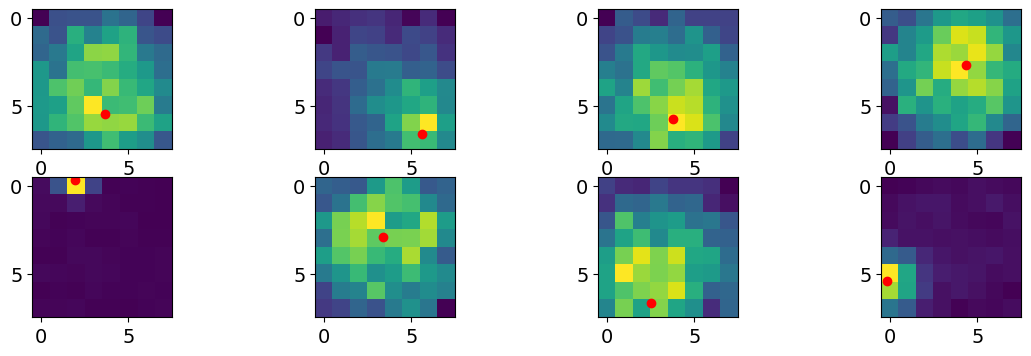

In [20]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [21]:
energy = get_energy2(imgs)

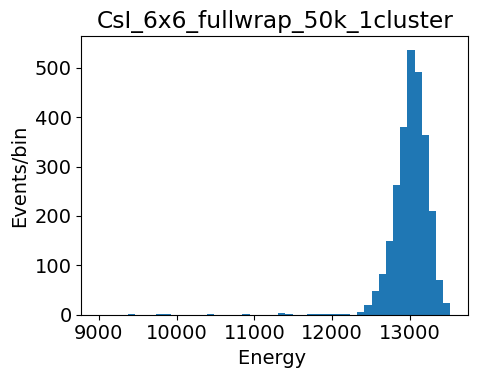

In [22]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=9000, xmax=max(energy),num_bins = 50)

## Load data
- No normalization. 

In [23]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [24]:
dataset = XDataset(dir_root, first_file, last_file,norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [25]:
dataset[3]

(tensor([[[114., 127., 157., 135., 205., 281., 412., 327.],
          [143., 146., 158., 172., 269., 344., 476., 424.],
          [137., 165., 170., 176., 239., 330., 426., 386.],
          [147., 153., 159., 156., 220., 310., 337., 325.],
          [137., 145., 155., 139., 159., 244., 259., 205.],
          [158., 152., 163., 151., 146., 171., 173., 163.],
          [178., 142., 155., 165., 165., 143., 169., 129.],
          [123., 141., 111., 152., 138., 124., 118., 143.]]]),
 tensor(0))

In [26]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


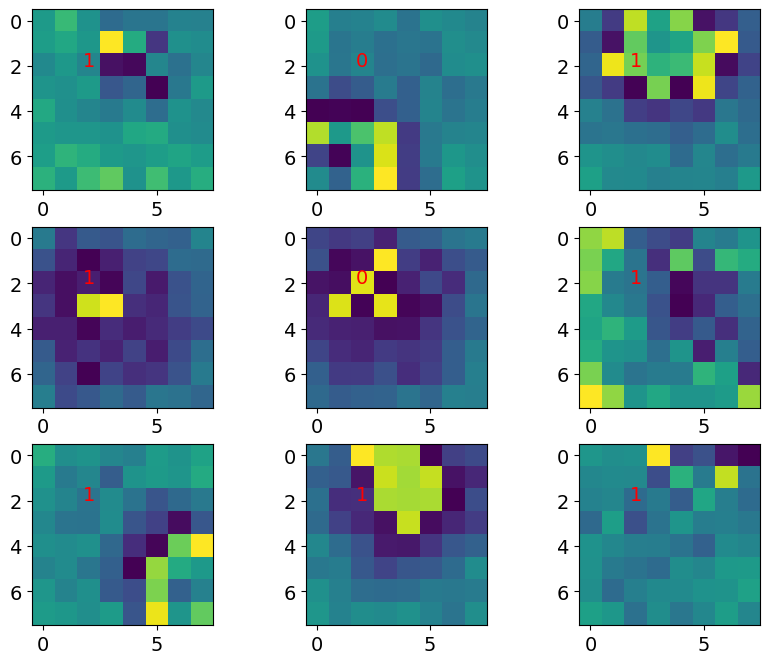

In [27]:
plot_images_and_labels(train_loader, start=500, figsize=(10, 8))

## Define model

In [28]:
CL = []
c1 = Conv2dPars(in_channels=1, out_channels=64, kernel_size=3, padding=1)
c2 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
c3 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=2, padding=1)
c4 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=2, padding=1)
p2d = MaxPool2dPars(kernel_size=2, stride=2)
CL.append(build_conv_layer(c1, p2d, relu='standard'))
CL.append(build_conv_layer(c2, p2d, relu='standard'))
CL.append(build_conv_layer(c3, p2d, relu='standard'))
CL.append(build_conv_layer(c4, p2d, relu='standard'))
clyrs = build_conv_layers(CL)

In [29]:
cnn_evaluation(torch.randn(1,1,8,8), CL)

shape of input image = torch.Size([1, 1, 8, 8])
 after cl = 1, shape of out image = torch.Size([1, 64, 4, 4])
 after cl = 2, shape of out image = torch.Size([1, 128, 2, 2])
 after cl = 3, shape of out image = torch.Size([1, 256, 1, 1])
 after cl = 4, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [30]:
LLYR=[]
LLYR.append(LinealLayerPars(512, 256))
LLYR.append(LinealLayerPars(256, 128))
LLYR.append(LinealLayerPars(128, 2))
llyrs = build_linear_layers(LLYR, df=0.25)

In [31]:
model = CNN(clyrs,llyrs).to(device)

In [32]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [34]:
x_single_run(train_loader, device, model, optimizer, criterion, xc=True)

** Run for 1 event**
epoch = 0
i = 0
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8])
labels = tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0])
outputs = torch.Size([100, 2])
predicted label = tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1], device='cuda:0')
correct = 42
Train Step 1/3590, Loss: 0.7002288699150085
i = 1
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8

In [35]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6656631529165178
--- EPOCH 0 AVG VAL LOSS: 0.6500448683897654
Accuracy on the 1026 validation images: 60.3194414649843 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.6374879055036475
--- EPOCH 1 AVG VAL LOSS: 0.6321534598082826
Accuracy on the 1026 validation images: 61.84546677847768 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6293506164238646
--- EPOCH 2 AVG VAL LOSS: 0.6382070363265032
Accuracy on the 1026 validation images: 61.83474072196111 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.6243610867

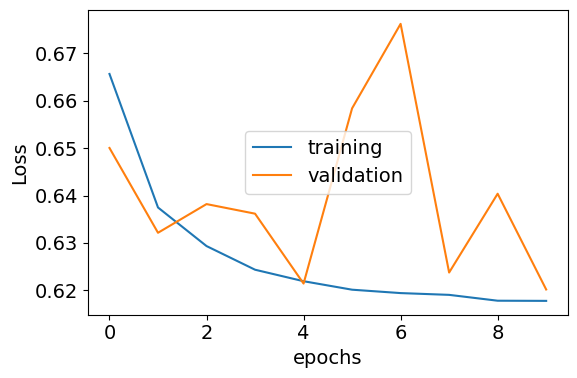

In [36]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

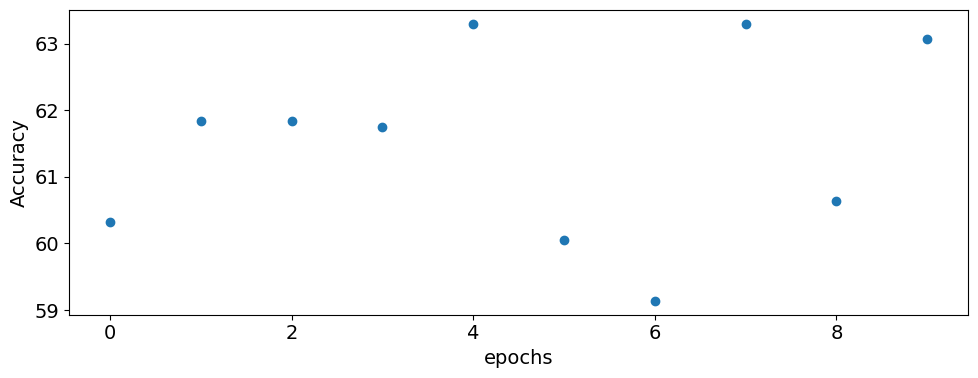

In [37]:
plot_accuracy(acc,figsize=(10, 4))

## Normalization

In [40]:
means, stds = get_means_stds2(dir=d1c)

files in dir: 100
shape -> (2742, 8, 8)
mean img0 =200.9375
std  img0 =49.51542663574219


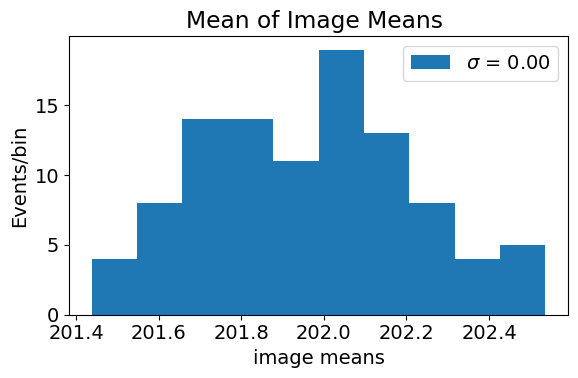

In [45]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [46]:
imean = np.mean(meansx)

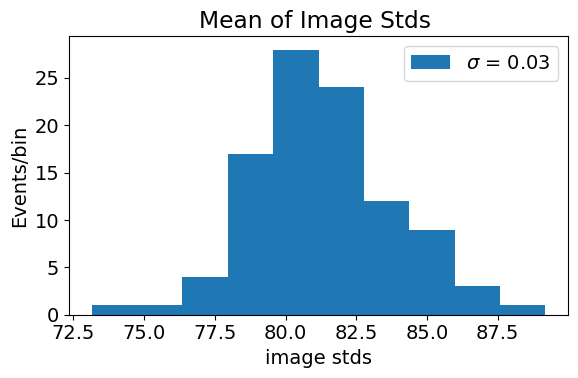

In [47]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [48]:
isigma = np.mean(stdsx)

In [49]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 201.9618682861328, std = 81.35904693603516


In [50]:
means2, stds2 = get_means_stds2(dir=d2c)

files in dir: 100
shape -> (1778, 8, 8)
mean img0 =205.46875
std  img0 =33.66422653198242


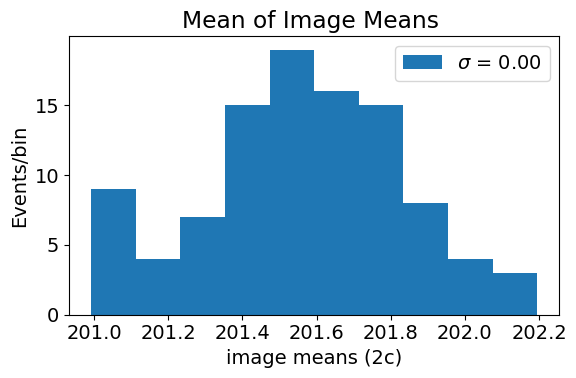

In [51]:
meansx2 =[np.mean(x) for x in means2]
histoplot(meansx2, "image means (2c)", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [52]:
imean2 = np.mean(meansx2)

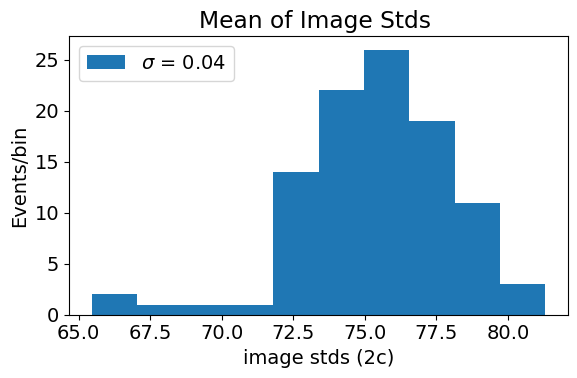

In [53]:
stdsx2 =[np.std(x) for x in stds2]
histoplot(stdsx2, "image stds (2c)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [54]:
isigma2 = np.mean(stdsx2)

In [55]:
print(f"Normalization 2c: mean = {imean2}, std = {isigma2}")

Normalization 2c: mean = 201.55828857421875, std = 75.29993438720703


In [56]:
means3, stds3 = get_means_stds2(dir=dnc)

files in dir: 100
shape -> (571, 8, 8)
mean img0 =199.09375
std  img0 =60.000186920166016


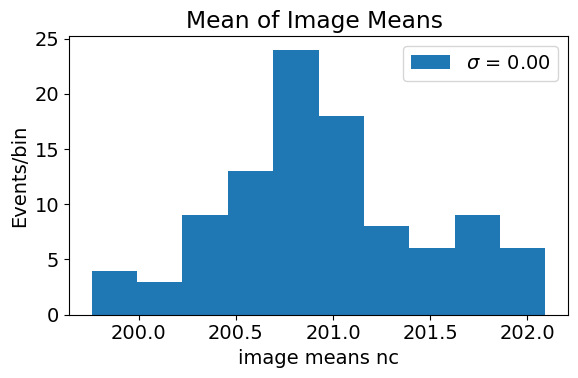

In [57]:
meansx3 =[np.mean(x) for x in means3]
histoplot(meansx3, "image means nc", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [58]:
imean3 = np.mean(meansx3)

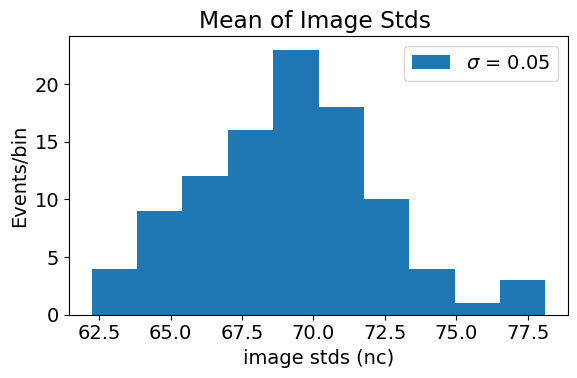

In [59]:
stdsx3 =[np.std(x) for x in stds3]
histoplot(stdsx3, "image stds (nc)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [60]:
isigma3 = np.mean(stdsx3)

In [61]:
print(f"Normalization nc: mean = {imean3}, std = {isigma3}")

Normalization nc: mean = 200.9595947265625, std = 69.10317993164062


### Run with full stats and normalization

In [62]:
dataset = XDataset(dir_root, first_file, last_file,norm=True, mean=imean, std=isigma)  # No comparison with energy only xyz


Running XDataset with norm = True
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_9mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [63]:
dataset[3]

(tensor([[[-1.0812, -0.9214, -0.5526, -0.8230,  0.0373,  0.9715,  2.5816,
            1.5369],
          [-0.7247, -0.6878, -0.5403, -0.3683,  0.8240,  1.7458,  3.3683,
            2.7291],
          [-0.7985, -0.4543, -0.3928, -0.3191,  0.4552,  1.5737,  2.7537,
            2.2620],
          [-0.6755, -0.6018, -0.5281, -0.5649,  0.2217,  1.3279,  1.6598,
            1.5123],
          [-0.7985, -0.7001, -0.5772, -0.7739, -0.5281,  0.5167,  0.7011,
            0.0373],
          [-0.5403, -0.6141, -0.4789, -0.6264, -0.6878, -0.3806, -0.3560,
           -0.4789],
          [-0.2945, -0.7370, -0.5772, -0.4543, -0.4543, -0.7247, -0.4051,
           -0.8968],
          [-0.9705, -0.7493, -1.1180, -0.6141, -0.7862, -0.9582, -1.0320,
           -0.7247]]]),
 tensor(0))

In [64]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


In [65]:
model = CNN(clyrs,llyrs).to(device)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [67]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.618478249075685
--- EPOCH 0 AVG VAL LOSS: 0.6227753790382289
Accuracy on the 1026 validation images: 62.90832146966476 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.615211525501315
--- EPOCH 1 AVG VAL LOSS: 0.6352181678626969
Accuracy on the 1026 validation images: 60.86159486709441 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6134999230545544
--- EPOCH 2 AVG VAL LOSS: 0.6107305508491822
Accuracy on the 1026 validation images: 64.42654601478246 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.61337641919

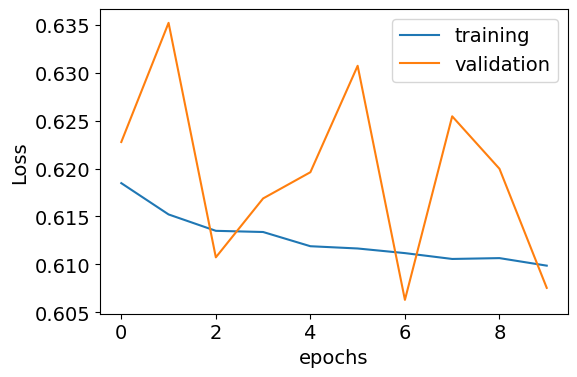

In [68]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

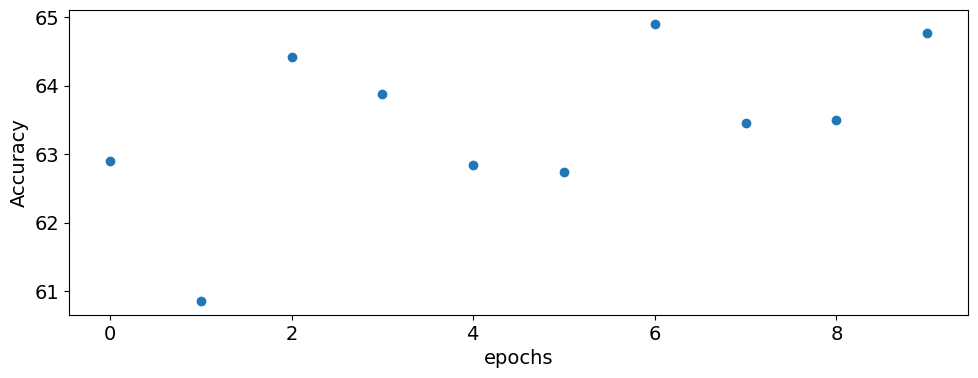

In [69]:
plot_accuracy(acc,figsize=(10, 4))

## Resnet

In [70]:
model = ResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [71]:
model(torch.randn(10,1,8,8).to(device))

  ResNet8: input data shape =>torch.Size([10, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([10, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([10, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([10, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([10, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([10, 512])
  ResNet8: after fc =>torch.Size([10, 2])


tensor([[-0.0544, -0.0204],
        [ 0.2545, -0.0655],
        [ 1.4070, -0.4667],
        [ 0.5023,  1.0638],
        [ 0.9462,  0.5010],
        [ 0.8123, -0.1536],
        [ 0.6994,  0.1643],
        [-0.5570, -0.3121],
        [-0.5102, -0.6832],
        [ 1.5397,  0.4313]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [72]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
         ResBlock-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 4, 4]          73,856
      BatchNorm2d-12            [-1, 128, 4, 4]             256
             ReLU-13            [-1, 128, 4, 4]               0
           Conv2d-14            [-1, 12

In [73]:
optimizer= optim.Adam(model.parameters(), lr=0.001)

In [74]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6504066025646285
--- EPOCH 0 AVG VAL LOSS: 0.6228949021526248
Accuracy on the 1026 validation images: 62.21990366051056 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.6161260115486001
--- EPOCH 1 AVG VAL LOSS: 0.6105774955036115
Accuracy on the 1026 validation images: 64.18959767537102 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6049670191694435
--- EPOCH 2 AVG VAL LOSS: 0.615015044895529
Accuracy on the 1026 validation images: 64.34756323497865 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.5964858007

In [75]:
optimizer= optim.Adam(model.parameters(), lr=0.01)

In [76]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6206984888876381
--- EPOCH 0 AVG VAL LOSS: 0.6333158351408343
Accuracy on the 1026 validation images: 62.83908965033056 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.6054744107643542
--- EPOCH 1 AVG VAL LOSS: 0.6136737374941044
Accuracy on the 1026 validation images: 64.7376016537629 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.5975823515720022
--- EPOCH 2 AVG VAL LOSS: 0.5928897921860102
Accuracy on the 1026 validation images: 66.27922850400765 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.5922607880

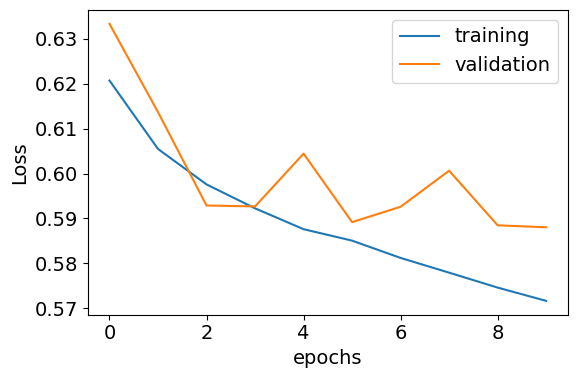

In [77]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

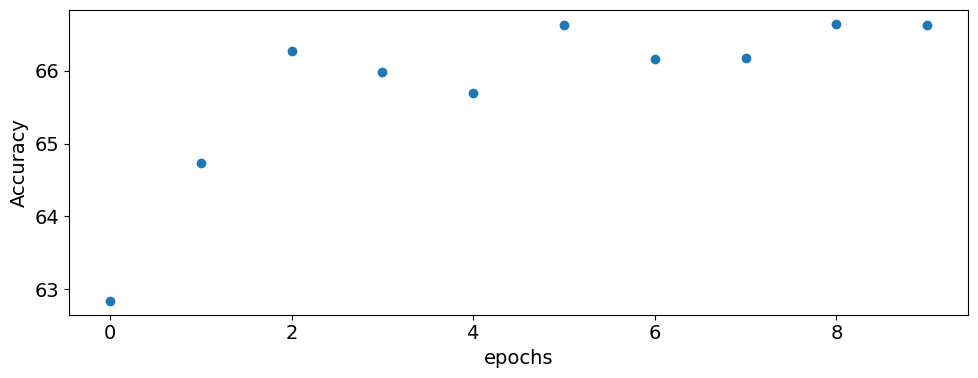

In [78]:
plot_accuracy(acc,figsize=(10, 4))